# Step 1: Fetching Twitter Data

I'm using Tweepy to get all the needed data.
The code works fine on PyCharm, but I'm not sure why it always failed on Python Notebook. Maybe you can try to run it on different tools.


In [1]:
import tweepy
import networkx as nx
import matplotlib
import re
from collections import defaultdict

#I deleted these keys because I think they're sensitive....
consumer_key=""
consumer_secret=""
access_token=""
access_token_secret=""

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

#Trying out whether the tweepy is working fine.....
#public_tweets = api.home_timeline()
#for tweet in public_tweets:
 #   print(tweet.text)

    
#Still trying..
user = api.get_user('3010631110')
follower_id = api.followers_ids('NOCHlLLVlNES')
friends_ids = api.friends_ids('NOCHlLLVlNES')
follower = api.followers('NOCHlLLVlNES')
#print(friends_ids)
#print(follower)
print(user)


"""print(user.screen_name)
print(user.followers_count)
for friend in user.friends():
   print(friend.screen_name)
   print(friend.id)

myself = api.me()
print(myself)"""



saveFile = open('Real_Twitter_Scraper.txt','w')

class CustomStreamListener(tweepy.StreamListener):
    def on_status(self, status):

        if '' in status.text.lower():
            #In these lines, I may choose to save different things if I need.
            #print(status.text)
            #print(status.name)
            #print(status.screen_name)
            print(status.id)
            for text in status.text:
                if text.startswith('RT'):
                    continue
                else:
                    #saveFile.write(str(id))
                    saveFile.write(text)

                    #print('Written succeed!')

    def on_error(self, status_code):
        print >> sys.stderr, 'Encountered error with status code:', status_code
        return True # Don't kill the stream

    def on_timeout(self):
        print >> sys.stderr, 'Timeout...'
        return True # Don't kill the stream


#Following 2 lines will return infinite fetching. So I quoted em.
#sapi = tweepy.streaming.Stream(auth, CustomStreamListener())
#sapi.filter(track=['Trump'])

TweepError: [{'code': 215, 'message': 'Bad Authentication data.'}]

# Step 2: Cosine Similarity Cluster
I used your scluster and modified a little bit. Now, the cluster will return the sorted clusters with the most popular cluster at the beginning. 

However, there's a FLAW. I didn't remove your original function inside, which means the function will return the original return values first, then run my modified code. I left this "flaw" here because of two reasons:
    1. I may need to view the results by myself. Modified version is not that readable.
    2. I'm lazy...zzzzz...
LOL... OK, just kidding. I promise I'll make the code nice and clean during the summer vocation.

In [2]:
# -*- coding: utf-8 -*-
"""A command-line tool to quickly cluster sentences.

usage:
    sclust [--help --threshold <T> --update-norms <N>]

Options
    -h, --help
    -t, --threshold <N>    Similarity threshold in [0,1]. Higher means sentences must be more similar to be merged. [default: .2]
    -u, --update-norms <N>    Update cluster norms every N documents. Larger values reduce run-time, but sacrifice accuracy. [default: 1]
"""
from collections import Counter, defaultdict
from docopt import docopt
from math import sqrt, log10
import numpy as np
import re
import sys


def norm(tokens, idfs):
    return sqrt(np.sum((count * idfs[token])**2
                       for token, count in tokens.items()))

def norm_dict(tokens, idfs):
    d = defaultdict(lambda: 0)
    denom = 0
    for token, count in tokens.items():
        v = count * idfs[token]
        d[token] = v
        denom += v*v
    denom = sqrt(denom)
    if denom == 0:
        denom = 1
    for token, val in d.items():
        d[token] = val / denom
    return d

def tokenize(line):
    return re.findall('\w+', line.lower())

def idf(token, doc_freqs, docnum):
    return log10((docnum + 1) / doc_freqs[token])

class Cluster:

    def __init__(self, token_counts, order):
        self.token_counts = Counter(token_counts)
        self.cluster_norm = None
        self.docnum = 0
        self.strings = []
        self.doc_freqs = Counter()
        self.order = order

    def add(self, tokens):
        self.token_counts.update(tokens)
    
    def add_string(self, string, tokens, index):
        self.docnum += 1
        self.doc_freqs.update(tokens)
        self.strings.append((string, tokens, index))
        
    def calculate_idf(self):
        self.idfs = {token: idf(token, self.doc_freqs, self.docnum) for token, value in self.doc_freqs.items()}
        
    def score(self, normed_doc, idfs, do_update_norm):
        if do_update_norm or not self.cluster_norm:
            self.normed_cluster = norm_dict(self.token_counts, idfs)
        return sum(value * self.normed_cluster[token] for token, value in normed_doc.items())

def update_index(index, clusterid, tokens):
    for t in tokens:
        index[t].add(clusterid)

def search_index(index, top_words):
    clusters = set()
    for w in top_words:
        clusters |= index[w]
    return clusters

def run(threshold, norm_update):
    order = 0
    doc_freqs = Counter()
    clusters = []
    docnum = 0
    index = defaultdict(set)
    strings = []
    for line in sys.stdin:
        if line == "end\n":
            break
        strings.append(line.strip())
    for line in strings:
        docnum += 1        
        tokens = Counter(tokenize(line))
        if len(tokens) == 0:
            continue
        doc_freqs.update(tokens)
    idfs = {token: idf(token, doc_freqs, docnum) for token, value in doc_freqs.items()}
    i = 0
    for line in strings:
        i += 1
        tokens = Counter(tokenize(line))
        do_update_norm = True if i % norm_update == 0 else False
        normed_doc = norm_dict(tokens, idfs)
        # What are the five words with highest tfidf weight? Use to filter comparisons.
        top_words = sorted(tokens, key=lambda x: -normed_doc[x])[:5]  # (doc_freqs[token], token) for token in tokens)
        best_cluster = -1
        best_score = -1
        for ci in search_index(index, top_words):
            cluster = clusters[ci]
            score = cluster.score(normed_doc, idfs, do_update_norm)
            if score > best_score and score > threshold:
                best_cluster = ci
                best_score = score
        if best_cluster == -1:
            clusters.append(Cluster(tokens, order))
            update_index(index, len(clusters)-1, tokens)
            print('%d\t%s\t-' % (len(clusters)-1, line))
            clusters[len(clusters)-1].add_string(line, tokens, i-1)
            order += 1
        else:
            clusters[best_cluster].add(tokens)
            update_index(index, best_cluster, tokens)
            print('%d\t%s\t%g' % (best_cluster, line, best_score))
            clusters[best_cluster].add_string(line, tokens, i-1)
        sys.stdout.flush()
    clusters = sorted(clusters, key = lambda c: len(c.strings), reverse = True)
    i = 0
    for cluster in clusters:
        cluster.calculate_idf()
        scores = []
        for string, tokens, index in cluster.strings:
            normed_doc = norm_dict(tokens, cluster.idfs)
            score = cluster.score(normed_doc, cluster.idfs, False)
            scores.append((string, score, index))
        k = 10
        top_k = sorted(scores, key = lambda t: t[1], reverse = True)[:k]
        print("\nTop %d strings in cluster %d:" % (k, cluster.order))
        n = 0
        for string, score, index in top_k:
            print("%d\t%s\t%g\tAt %d" % (n, string, score, index))
            n += 1
        i += 1
    

# Weirdness when piping to unix tools. See http://stackoverflow.com/a/26736013/1756896
def _void_f(*args,**kwargs):
    pass

def main():
    args = docopt(__doc__)
    try:
        run(float(args['--threshold']),
            int(args['--update-norms']))
    except (BrokenPipeError, IOError):
        sys.stdout.write = _void_f
        sys.stdout.flush = _void_f
        sys.exit()



if __name__ == '__main__':
    main()



DocoptExit: usage:
    sclust [--help --threshold <T> --update-norms <N>]

To exit: use 'exit', 'quit', or Ctrl-D.


# Step 3: Visualization
Now, I'm using NetworkX to draw the relationships of related accounts. By visualization, some interesting relationships will merge.

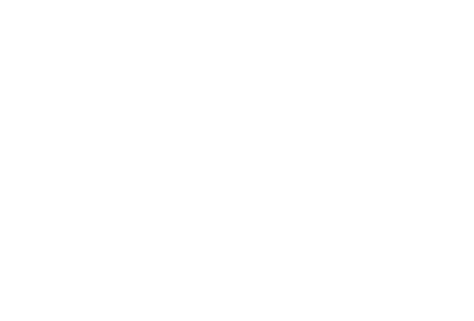

In [3]:
import networkx as nx
import matplotlib as mb
import matplotlib.pyplot as plt  
%matplotlib inline
graph = nx.DiGraph()
#It's an unfinished version. This function should read the lists in the .txt file.
#But I'm just trying to show the thought of structure in my mind.
list_ids = []
for id in list_ids:
    for id2 in list_ids:
        if id == id2:
            continue
        if id.is_friendship(id2):
            graph.add_edges_from([(id, id2)])


nx.draw(graph, with_labels=True)